In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv('preprocessed_trade_data.csv')

In [37]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902824 entries, 0 to 902823
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   state                902824 non-null  int64  
 1   apmc                 902824 non-null  int64  
 2   commodity            902824 non-null  int64  
 3   min_price            902824 non-null  float64
 4   modal_price          902824 non-null  float64
 5   max_price            902824 non-null  float64
 6   commodity_arrivals   902819 non-null  float64
 7   commodity_traded     902819 non-null  float64
 8   price_spread         902824 non-null  float64
 9   price_ratio          902824 non-null  float64
 10  demand_supply_ratio  902819 non-null  float64
 11  month                902824 non-null  int64  
 12  day_of_week          902824 non-null  int64  
 13  year                 902824 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 96.4 MB
None


In [44]:
sequence_length = 30  # Number of past days to look at for prediction
target_price = 'modal_price'  # Target for price recommendation
target_trade = 'commodity_traded'  # Target for trade prediction
features = ['min_price', 'max_price', 'commodity_arrivals', 'commodity_traded',
            'price_spread', 'price_ratio', 'demand_supply_ratio', 'month', 'day_of_week']

In [45]:
# Function to create sequences for LSTM
def create_sequences(data, target_col, features, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

In [46]:
# Filter data for a specific commodity (can be generalized to all)
commodity_id = 1  # Example: Commodity with ID 1
filtered_data = data[data['commodity'] == commodity_id]

In [47]:
# Create sequences for price recommendation
X_price, y_price = create_sequences(filtered_data, target_price, features, sequence_length)

In [48]:
# Create sequences for trade prediction
X_trade, y_trade = create_sequences(filtered_data, target_trade, features, sequence_length)

In [49]:
# Split into train and test sets
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
X_trade_train, X_trade_test, y_trade_train, y_trade_test = train_test_split(X_trade, y_trade, test_size=0.2, random_state=42)

In [10]:
# Function to build and train LSTM models
def build_and_train_lstm(X_train, y_train, X_test, y_test, target_name):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{target_name} Prediction - Training History")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"{target_name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return model, predictions


Training LSTM for Price Recommendation...
Epoch 1/100


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1032 - mae: 0.3094 - val_loss: 0.0081 - val_mae: 0.0901
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0119 - mae: 0.0863 - val_loss: 0.0641 - val_mae: 0.2531
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0820 - mae: 0.2734 - val_loss: 0.0510 - val_mae: 0.2258
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0728 - mae: 0.2640 - val_loss: 0.0168 - val_mae: 0.1295
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0063 - mae: 0.0677 - val_loss: 0.0019 - val_mae: 0.0433
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0145 - mae: 0.0927 - val_loss: 0.0020 - val_mae: 0.0441
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0149 - mae: 0.1039 - val_loss: 0.0097 - val_mae: 0.0982
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0172 - mae: 0.1250 - val_loss: 0.0165 - val_mae: 0.1280
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0158 - mae: 0.1073 - val_l

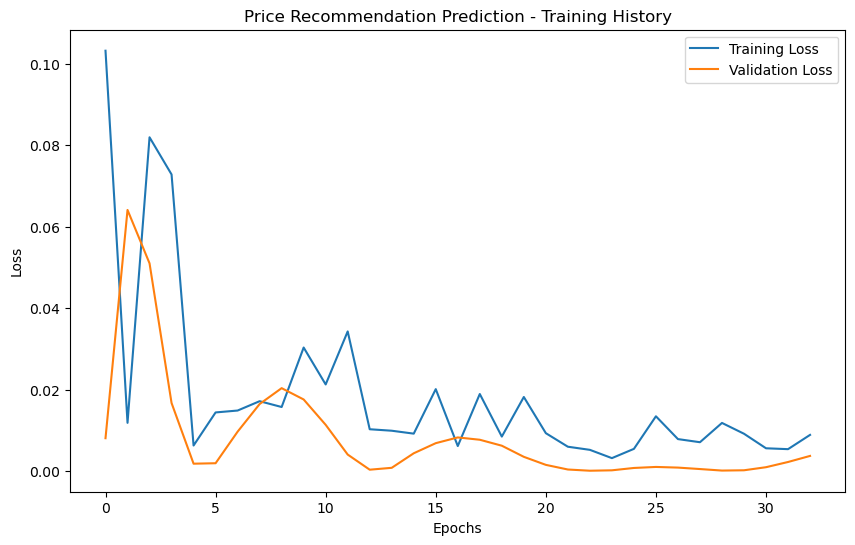

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Price Recommendation - MSE: 0.0002, R2: -1613.7623


In [11]:
# Train the LSTM for Price Recommendation
print("\nTraining LSTM for Price Recommendation...")
price_model, price_predictions = build_and_train_lstm(X_price_train, y_price_train, X_price_test, y_price_test, "Price Recommendation")


Training LSTM for Trade Prediction...
Epoch 1/100


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0477 - mae: 0.1743 - val_loss: 0.0172 - val_mae: 0.1270
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0265 - mae: 0.1446 - val_loss: 0.0268 - val_mae: 0.1610
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0285 - mae: 0.1490 - val_loss: 0.0079 - val_mae: 0.0837
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0372 - mae: 0.1655 - val_loss: 0.0013 - val_mae: 0.0350
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0141 - mae: 0.0946 - val_loss: 0.0042 - val_mae: 0.0575
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0150 - mae: 0.1024 - val_loss: 0.0095 - val_mae: 0.0932
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0569 - mae: 0.1808 - val_loss: 0.0037 - val_mae: 0.0553
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0503 - mae: 0.1872 - val_loss: 6.9804e-04 - val_mae: 0.0261
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0269 - mae: 0.1266 - v

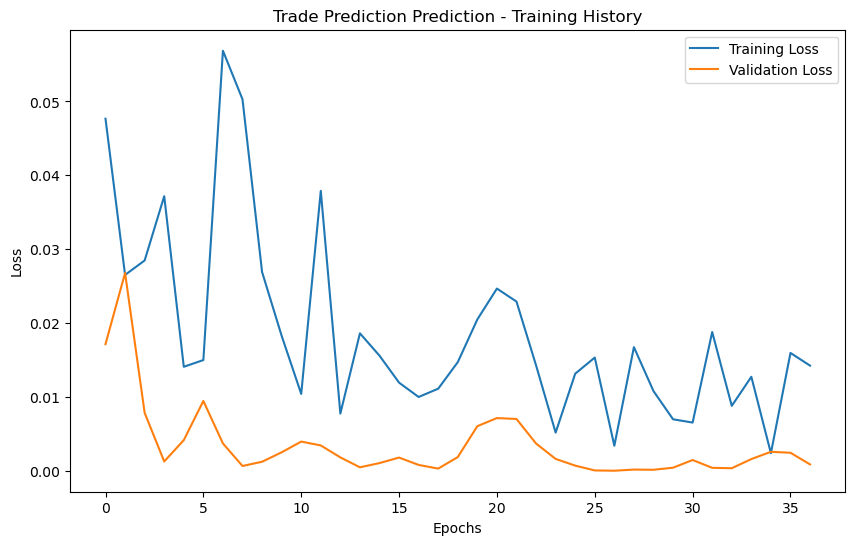

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Trade Prediction - MSE: 0.0001, R2: -9158542.5703


In [12]:
# Train the LSTM for Trade Prediction
print("\nTraining LSTM for Trade Prediction...")
trade_model, trade_predictions = build_and_train_lstm(X_trade_train, y_trade_train, X_trade_test, y_trade_test, "Trade Prediction")

In [14]:
# Save models
price_model.save("price_recommendation_model.keras")
trade_model.save("trade_prediction_model.keras")

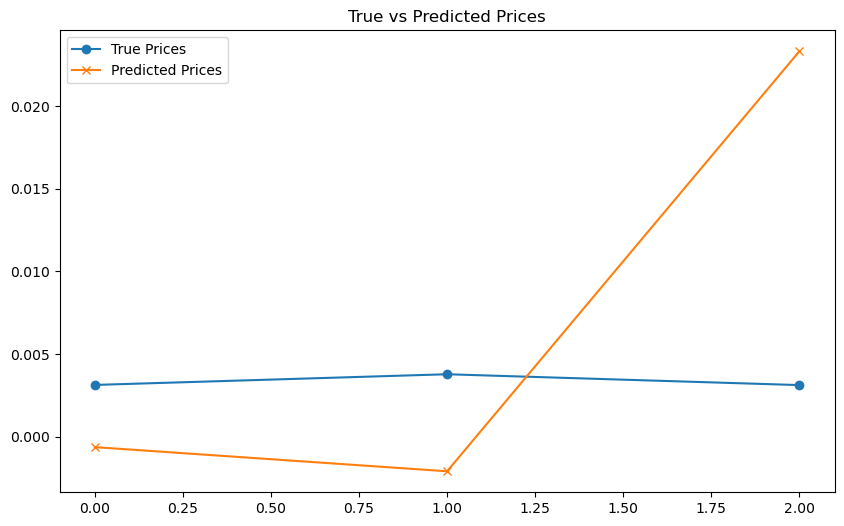

In [15]:
# Example visualization: True vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_price_test[:50], label="True Prices", marker='o')
plt.plot(price_predictions[:50], label="Predicted Prices", marker='x')
plt.title("True vs Predicted Prices")
plt.legend()
plt.show()

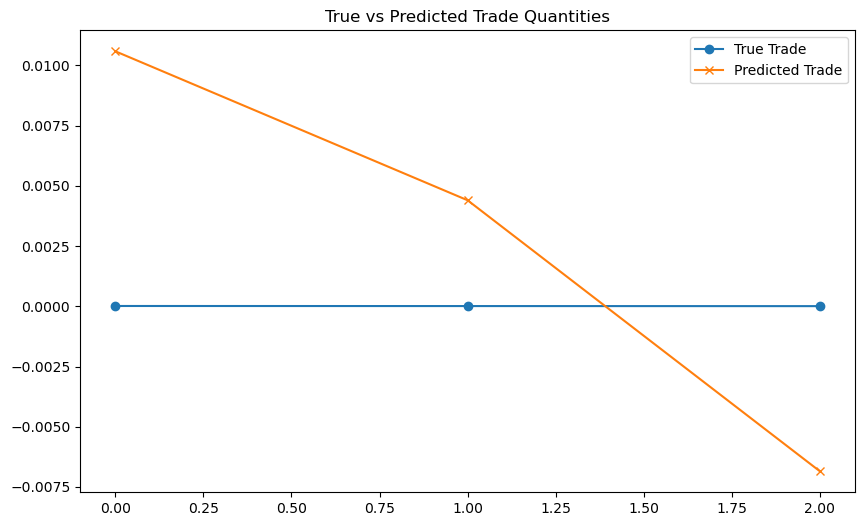

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_trade_test[:50], label="True Trade", marker='o')
plt.plot(trade_predictions[:50], label="Predicted Trade", marker='x')
plt.title("True vs Predicted Trade Quantities")
plt.legend()
plt.show()